# Table of Contents | ASD DATA 

- [The BREAST-CANCER dataset](#The-BREAST-CANCER-dataset):
    - [Load the dataset](#Load-the-Dataset)
    - [Explore the dataset: Descriptive statistics](#Explore-the-dataset:-Descriptive-statistics)
    - [Explore the dataset: Visualization](#Explore-the-dataset:-Visualization)
    



The entire project has been based on the following study [Investigating the Correspondence of Clinical  Diagnostic Grouping With Underlying Neurobiological and Phenotypic Clusters Using Unsupervised Machine Learning](https://doi.org/10.1016/j.dib.2018.01.080).

The work focuses on two different pathologies in brain disorders: ASD and ADHD

## The ASD dataset

available at [ABIDE I database](https://fcon_1000.projects.nitrc.org/indi/abide/abide_I.html).


This is .......
 
This data set includes 286 intances (201 of one class, 85 of another class).  The instances are described by 9 attributes, some of which are ordinal and some are nominal.
 
Attribute information

| column | values |
| --- | --- |
| Class | no-recurrence-events, recurrence-events |
| age | 10-19, 20-29, 30-39, 40-49, 50-59, 60-69, 70-79, 80-89, 90-99|
| menopause | lt40, ge40, premeno|
| tumor-size | 0-4, 5-9, 10-14, 15-19, 20-24, 25-29, 30-34, 35-39, 40-44, 45-49, 50-54, 55-59|
| inv-nodes | 0-2, 3-5, 6-8, 9-11, 12-14, 15-17, 18-20, 21-23, 24-26, 27-29, 30-32, 33-35, 36-39|
| node-caps | yes, no|
| deg-malig | 1, 2, 3|
| breast | left, right|
| breast-quad | left-up, left-low, right-up, right-low, central|
| irradiat | yes, no|
 
There are 9 Missing Attribute Values (denoted by "?") 


In [90]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt #for the plots
import seaborn as sns 
import re
import OurFunctions as of

In [91]:
ASD_phenotypic = pd.read_csv(os.path.join('DataSets','Phenotypic Datasets','ASD','ASD_phenotypic.csv'))

In [92]:
#visualizziamo, non completamente, il nostro dataset
#e otteniamone la dimensione: prima info utile
ASD_phenotypic

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.40,1,R,NaN,126.0,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.90,1,Ambi,NaN,107.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.20,1,R,NaN,93.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.80,1,R,NaN,106.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.60,2,Ambi,NaN,133.0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,YALE,50624,1,3,11.08,2,R,NaN,90.0,91.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1108,YALE,50625,1,3,7.00,1,L,NaN,99.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1109,YALE,50626,1,3,11.08,1,L,NaN,61.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
1110,YALE,50627,1,3,9.50,2,R,NaN,88.0,103.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN


In [93]:
ASD_phenotypic.head() #in order to underline features

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_BLK_DSN_SCALED,WISC_IV_PIC_CON_SCALED,WISC_IV_MATRIX_SCALED,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI
0,CALTECH,51456,1,4,55.4,1,R,NaN,126.0,118.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
1,CALTECH,51457,1,4,22.9,1,Ambi,NaN,107.0,119.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
2,CALTECH,51458,1,1,39.2,1,R,NaN,93.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
3,CALTECH,51459,1,1,22.8,1,R,NaN,106.0,94.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN
4,CALTECH,51460,1,1,34.6,2,Ambi,NaN,133.0,135.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN


In [94]:
#otteniamo le informazioni relative al dataset
ASD_phenotypic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1112 entries, 0 to 1111
Data columns (total 74 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   SITE_ID                          1112 non-null   object 
 1   SUB_ID                           1112 non-null   int64  
 2   DX_GROUP                         1112 non-null   int64  
 3   DSM_IV_TR                        1112 non-null   int64  
 4   AGE_AT_SCAN                      1112 non-null   float64
 5   SEX                              1112 non-null   int64  
 6   HANDEDNESS_CATEGORY              797 non-null    object 
 7   HANDEDNESS_SCORES                370 non-null    float64
 8   FIQ                              1077 non-null   float64
 9   VIQ                              935 non-null    float64
 10  PIQ                              953 non-null    float64
 11  FIQ_TEST_TYPE                    947 non-null    object 
 12  VIQ_TEST_TYPE       

# OVERVIEW

In [95]:
ASD_phenotypic.shape

(1112, 74)

The dataset has 1112 raws anf 74 colums

## Missing Values analysis

Now we check the presence of missing values catalogated as None or numpy.NaN

In [96]:
nan_values = ASD_phenotypic.isna().sum()

# Filter columns with NaN values
columns_with_nan = nan_values[nan_values >= 0]

columns_with_nan_sorted = columns_with_nan.sort_values(ascending=False)

# Print the number of attributes with NaN values
print("Number of attributes with NaN values:", len(columns_with_nan))

# Print the columns with NaN values and their corresponding counts
print("Attributes with NaN values sorted in descending order and their counts:")
pd.set_option('display.max_rows', 74)
columns_with_nan_sorted



Number of attributes with NaN values: 74
Attributes with NaN values sorted in descending order and their counts:


WISC_IV_VOCAB_SCALED               1057
WISC_IV_WMI                        1057
WISC_IV_VCI                        1057
WISC_IV_SYM_SCALED                 1057
WISC_IV_CODING_SCALED              1057
WISC_IV_LET_NUM_SCALED             1057
WISC_IV_DIGIT_SPAN_SCALED          1057
WISC_IV_MATRIX_SCALED              1057
WISC_IV_PIC_CON_SCALED             1057
WISC_IV_BLK_DSN_SCALED             1057
WISC_IV_INFO_SCALED                1057
WISC_IV_PRI                        1057
WISC_IV_SIM_SCALED                 1057
WISC_IV_PSI                        1057
AQ_TOTAL                           1054
SRS_AWARENESS                      1048
COMORBIDITY                        1048
SRS_MANNERISMS                     1048
SRS_MOTIVATION                     1048
SRS_COMMUNICATION                  1048
SRS_COGNITION                      1048
AGE_AT_MPRAGE                      1011
OFF_STIMULANTS_AT_SCAN              971
SCQ_TOTAL                           969
MEDICATION_NAME                     955


Distribution of NANs

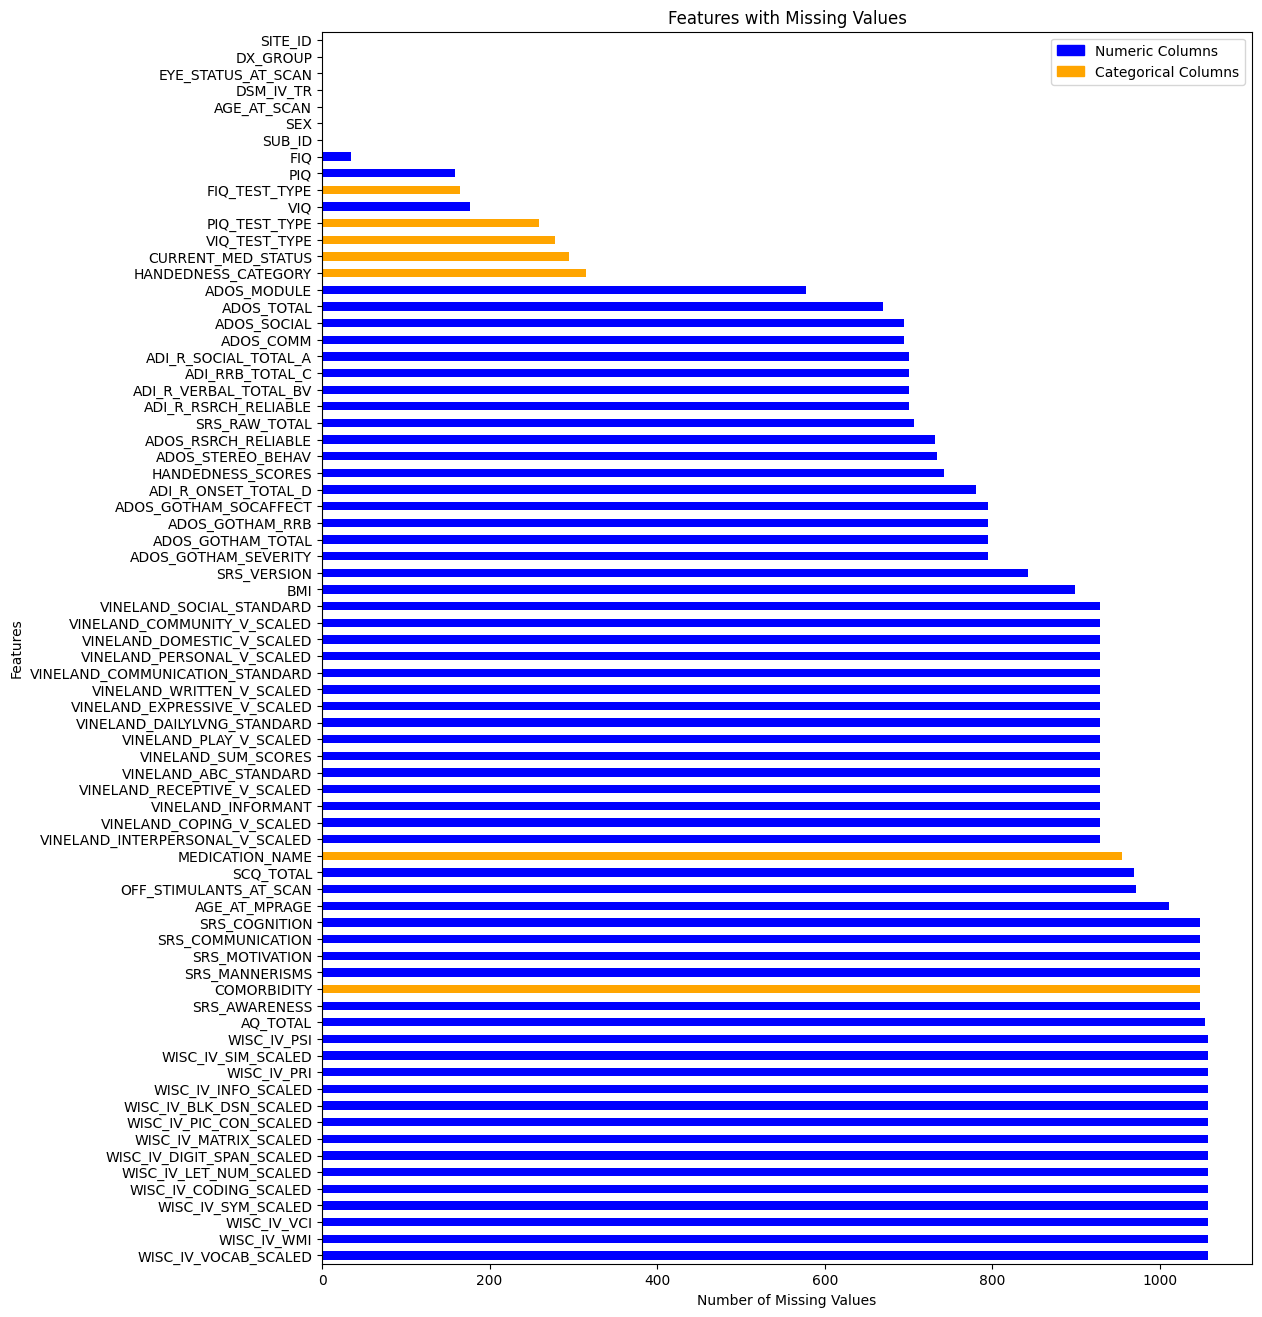

In [97]:
# Calcolo dei valori mancanti e ordinamento
nan_values = ASD_phenotypic.isna().sum()
columns_with_nan_sorted = nan_values.sort_values(ascending=False)

# Selezione delle colonne numeriche e categoriche
numeric_columns, categorical_columns = of.select_columns(ASD_phenotypic)

# Plot dei valori mancanti
of.plot_missing_values(columns_with_nan_sorted, numeric_columns)



We notice the huge amount of missing values in dataset. For this reason we can delete apriori those features containing an high percentage of missing values (< 50%>) in order to proceed in a more easy and consistent way.

## Brutal Filtering

In [98]:
# Calcola il numero totale di righe nel DataFrame
total_rows = len(ASD_phenotypic)

# Calcola il numero massimo di valori mancanti consentiti (65%)
max_missing_values = total_rows * 0.65

# Trova le colonne con un numero di valori mancanti superiore al limite consentito
columns_to_drop = []
for column, missing_count in columns_with_nan_sorted.items():
    if missing_count > max_missing_values:
        columns_to_drop.append(column)

# Rimuovi le colonne con un numero di valori mancanti eccessivo
ASD_phenotypic_filtered = ASD_phenotypic.drop(columns=columns_to_drop)

# Stampa le colonne rimosse
print("Le seguenti colonne sono state rimosse perché hanno più del 65% dei valori mancanti:")
for column in columns_to_drop:
    print(column)



Le seguenti colonne sono state rimosse perché hanno più del 65% dei valori mancanti:
WISC_IV_VOCAB_SCALED
WISC_IV_WMI
WISC_IV_VCI
WISC_IV_SYM_SCALED
WISC_IV_CODING_SCALED
WISC_IV_LET_NUM_SCALED
WISC_IV_DIGIT_SPAN_SCALED
WISC_IV_MATRIX_SCALED
WISC_IV_PIC_CON_SCALED
WISC_IV_BLK_DSN_SCALED
WISC_IV_INFO_SCALED
WISC_IV_PRI
WISC_IV_SIM_SCALED
WISC_IV_PSI
AQ_TOTAL
SRS_AWARENESS
COMORBIDITY
SRS_MANNERISMS
SRS_MOTIVATION
SRS_COMMUNICATION
SRS_COGNITION
AGE_AT_MPRAGE
OFF_STIMULANTS_AT_SCAN
SCQ_TOTAL
MEDICATION_NAME
VINELAND_INTERPERSONAL_V_SCALED
VINELAND_COPING_V_SCALED
VINELAND_INFORMANT
VINELAND_RECEPTIVE_V_SCALED
VINELAND_ABC_STANDARD
VINELAND_SUM_SCORES
VINELAND_PLAY_V_SCALED
VINELAND_DAILYLVNG_STANDARD
VINELAND_EXPRESSIVE_V_SCALED
VINELAND_WRITTEN_V_SCALED
VINELAND_COMMUNICATION_STANDARD
VINELAND_PERSONAL_V_SCALED
VINELAND_DOMESTIC_V_SCALED
VINELAND_COMMUNITY_V_SCALED
VINELAND_SOCIAL_STANDARD
BMI
SRS_VERSION
ADOS_GOTHAM_SEVERITY
ADOS_GOTHAM_TOTAL
ADOS_GOTHAM_RRB
ADOS_GOTHAM_SOCAFFECT
ADI_R

In [99]:
ASD_phenotypic_filtered

,SITE_ID,SUB_ID,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,FIQ,VIQ,PIQ,...,ADI_R_VERBAL_TOTAL_BV,ADI_RRB_TOTAL_C,ADI_R_RSRCH_RELIABLE,ADOS_MODULE,ADOS_TOTAL,ADOS_COMM,ADOS_SOCIAL,SRS_RAW_TOTAL,CURRENT_MED_STATUS,EYE_STATUS_AT_SCAN
0,CALTECH,51456,1,4,55.40,1,R,126.0,118.0,128.0,...,-9999.0,-9999.0,NaN,4.0,9.0,2.0,7.0,NaN,NaN,2
1,CALTECH,51457,1,4,22.90,1,Ambi,107.0,119.0,93.0,...,17.0,5.0,1.0,4.0,8.0,3.0,5.0,NaN,NaN,2
2,CALTECH,51458,1,1,39.20,1,R,93.0,80.0,108.0,...,18.0,7.0,1.0,4.0,20.0,6.0,14.0,NaN,NaN,2
3,CALTECH,51459,1,1,22.80,1,R,106.0,94.0,118.0,...,12.0,2.0,1.0,4.0,12.0,4.0,8.0,NaN,NaN,2
4,CALTECH,51460,1,1,34.60,2,Ambi,133.0,135.0,122.0,...,11.0,6.0,1.0,4.0,13.0,4.0,9.0,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1107,YALE,50624,1,3,11.08,2,R,90.0,91.0,89.0,...,10.0,4.0,1.0,3.0,NaN,NaN,NaN,51.0,NaN,1
1108,YALE,50625,1,3,7.00,1,L,99.0,90.0,98.0,...,23.0,4.0,1.0,3.0,NaN,NaN,NaN,126.0,NaN,1
1109,YALE,50626,1,3,11.08,1,L,61.0,66.0,60.0,...,24.0,6.0,1.0,3.0,NaN,NaN,NaN,-9999.0,NaN,1
1110,YALE,50627,1,3,9.50,2,R,88.0,103.0,84.0,...,11.0,6.0,1.0,3.0,NaN,NaN,NaN,118.0,NaN,1


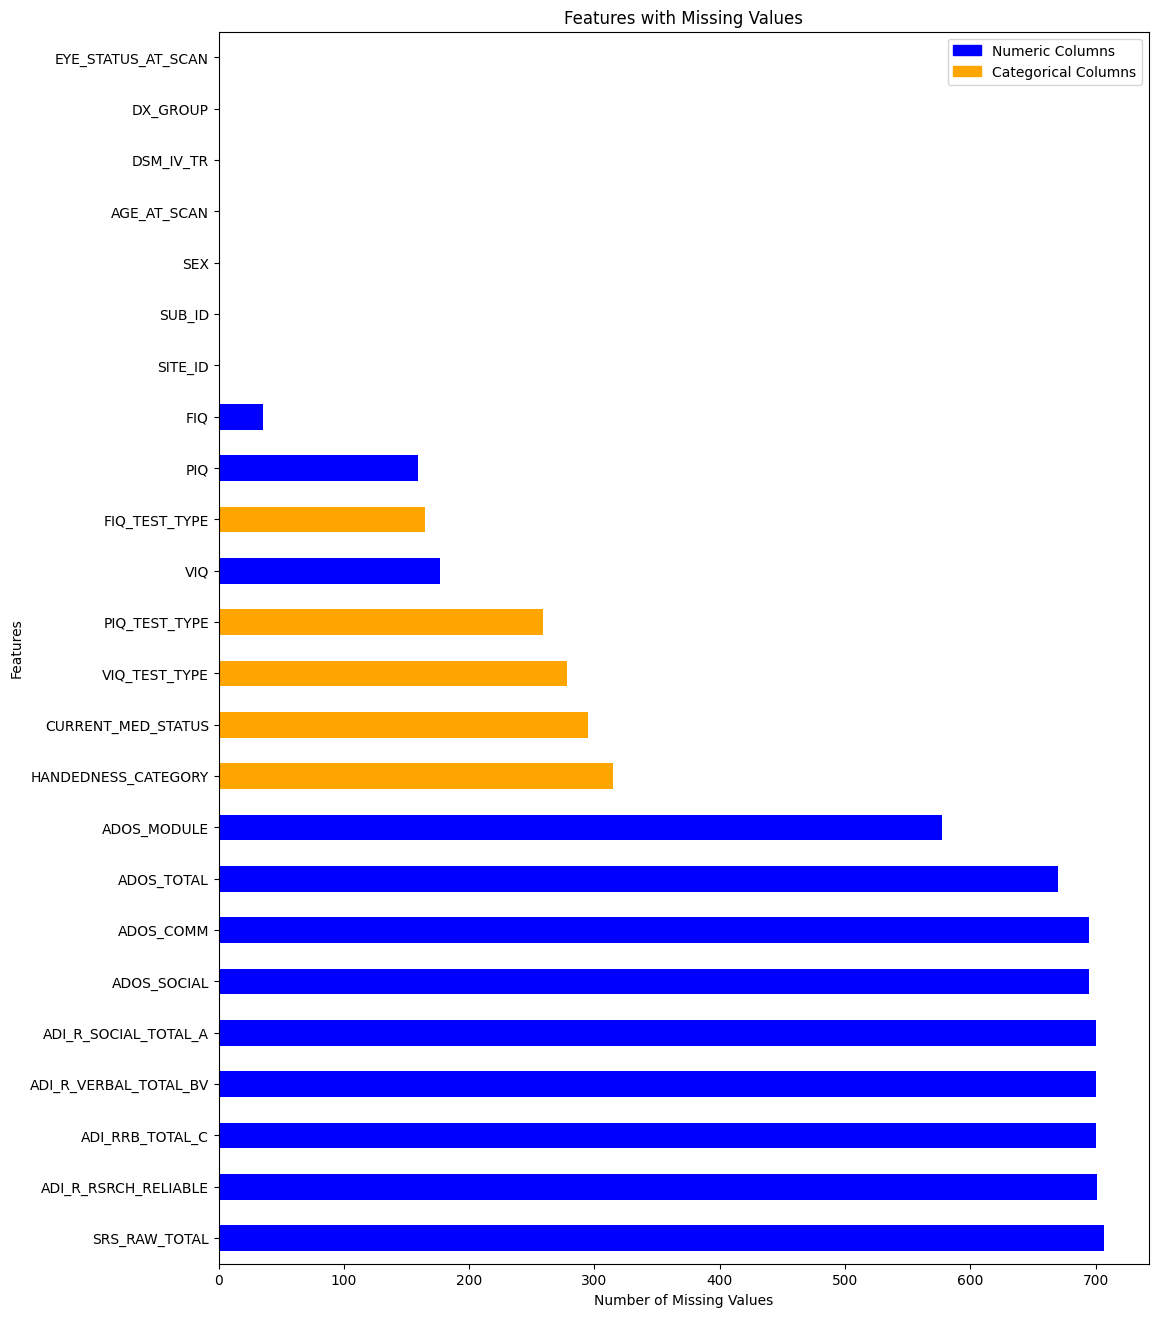

In [100]:
# Calcolo dei valori mancanti e ordinamento
nan_values_filtered = ASD_phenotypic_filtered.isna().sum()
columns_with_nan_sorted_filtered = nan_values_filtered.sort_values(ascending=False)

# Selezione delle colonne numeriche e categoriche
numeric_columns_filtered, categorical_columns_filtered = of.select_columns(ASD_phenotypic_filtered)


# Plot dei valori mancanti
of.plot_missing_values(columns_with_nan_sorted_filtered, numeric_columns_filtered)

#  CATEGORICAL EXPLORATION

In [101]:
# Ciclo su tutte le colonne di tipo 'category'
for column in categorical_columns_filtered:
    # Stampa il nome della colonna
    print("Feature:", column)
    # Stampa i valori unici della colonna
    unique_values = ASD_phenotypic_filtered[column].unique()
    for value in unique_values:
        print(value)
    print()


Feature: SITE_ID
CALTECH
CMU
KKI
LEUVEN_1
LEUVEN_2
MAX_MUN
NYU
OHSU
OLIN
PITT
SBL
SDSU
STANFORD
TRINITY
UCLA_1
UCLA_2
UM_1
UM_2
USM
YALE

Feature: HANDEDNESS_CATEGORY
R
Ambi
L
Mixed
L->R
nan
-9999

Feature: FIQ_TEST_TYPE
WASI
WAIS
WISC
WISC_IV_FULL
WAIS_III
WISC_III_DUTCH
WST
-9999
HAWIK_IV
WISC_IV_4_SUBTESTS
WISC_III
nan
GIT
DAS_II_SA

Feature: VIQ_TEST_TYPE
WASI
WAIS
WISC
nan
WAIS_III
GIT
WISC_IV_FULL
DAS_II_SA
WASI    
PPVT
WISC4   
PPVT    
ppvt
Stanford
WISC_III

Feature: PIQ_TEST_TYPE
WASI
WAIS
WISC
nan
WAIS_III
RAVENS
GIT
WISC_IV_FULL
DAS_II_SA
WASI    
Ravens
WISC4   
Ravens  
ravens
Stanford
WISC_III

Feature: CURRENT_MED_STATUS
nan
1
0
-9999
`



Exploding categorical features, we notice the presence of value -9999, commonly used to denote missing data or values out of range, so we are going to consider them as NaN.

In [102]:

# Ottieni i nomi delle colonne categoriche come una lista
categorical_column_names = categorical_columns_filtered.tolist()

'''We notice the presence of -9999 value in several features. 
In order to prevent this also in numerical features we evaluate this value as a NaN in 
the entire ASD_phenotypic_filtered'''

for column in ASD_phenotypic_filtered:
    
    # Replace -9999 and "-9999" with NaN
    ASD_phenotypic_filtered[column] = ASD_phenotypic_filtered[column].replace(['-9999', -9999], np.NaN)
    

'''We checked if the presence changing -9999 as NaN at the starting point produce relevant changes
in distribution of Missing Values in Dataset and subesequent brutal filtering and we found that
the changes are negligible. '''

    


C:\Users\auran\AppData\Local\Temp\ipykernel_1592\711235826.py:11: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ASD_phenotypic_filtered[column] = ASD_phenotypic_filtered[column].replace(['-9999', -9999], np.NaN)


'We checked if the presence changing -9999 as NaN at the starting point produce relevant changes\nin distribution of Missing Values in Dataset and subesequent brutal filtering and we found that\nthe changes are negligible. '

To understand better how to treat the information gived by this categorical variables we are interested in know which values are stored in this features. We will analyze all of them.


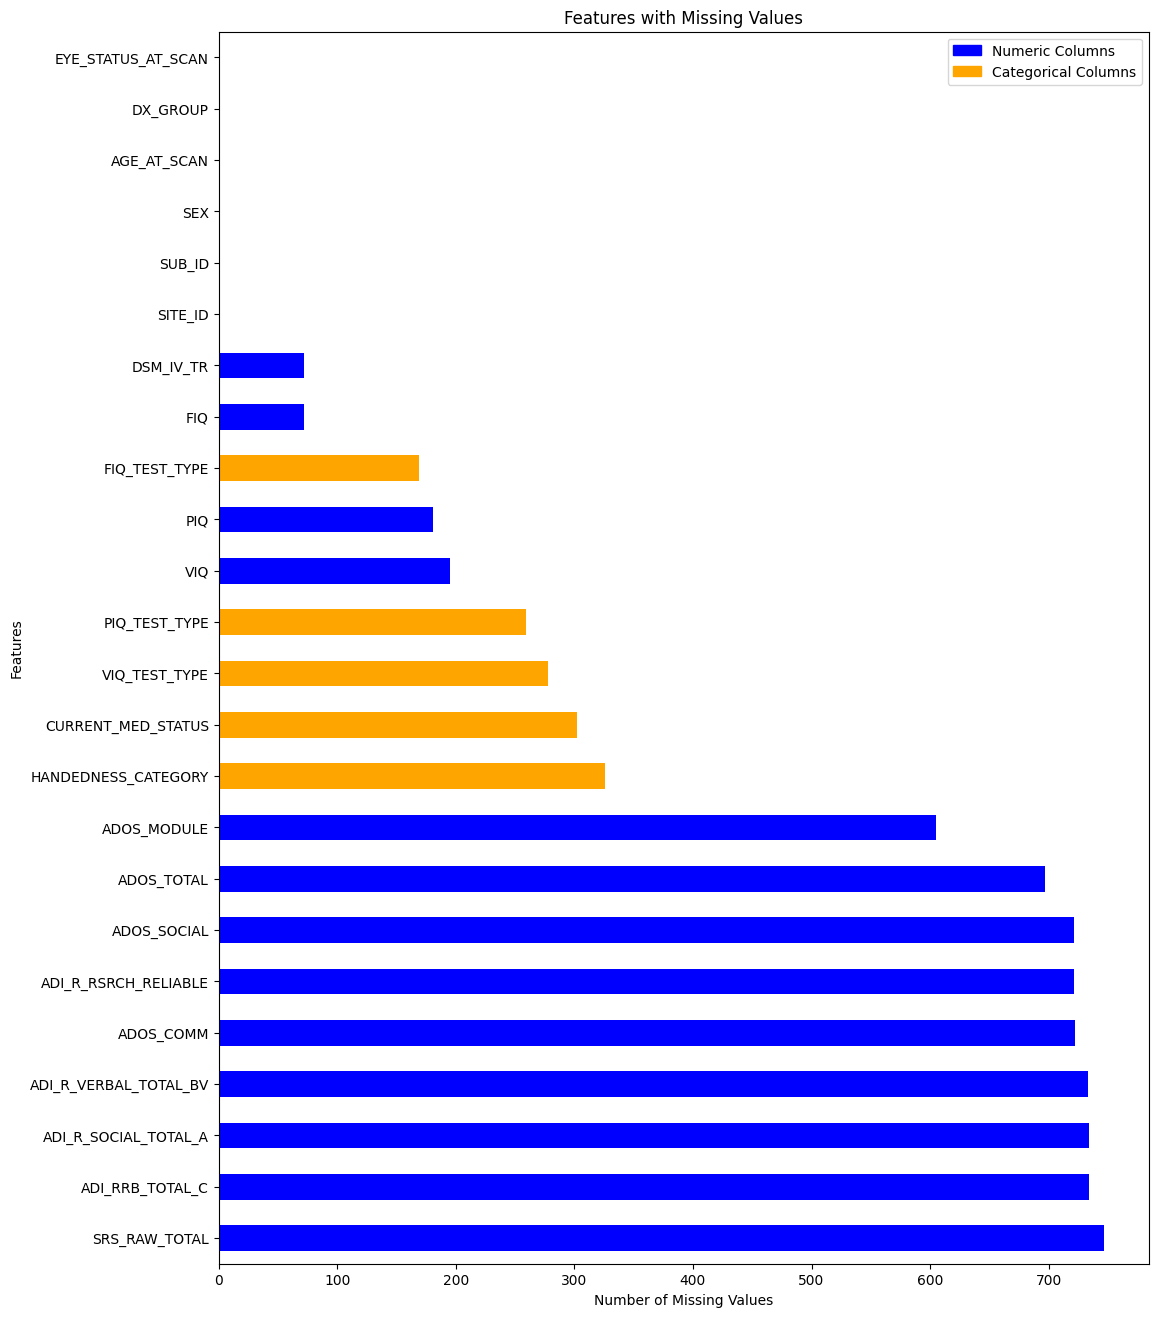

In [103]:
# Calcolo dei valori mancanti e ordinamento
nan_values_filtered = ASD_phenotypic_filtered.isna().sum()
columns_with_nan_sorted_filtered = nan_values_filtered.sort_values(ascending=False)

# Selezione delle colonne numeriche e categoriche
numeric_columns_filtered, categorical_columns_filtered = of.select_columns(ASD_phenotypic_filtered)


# Plot dei valori mancanti
of.plot_missing_values(columns_with_nan_sorted_filtered, numeric_columns_filtered)

## Handling categorical variables

Thanks to the implemented tolist, we can acced to specific elements.
We prefer create viasual subsections in order to manage these features, but we could implement a 'for logic' in order to guarantee a correct automatic work also in case of modifications on dataset.

For each categorical feature, we want to investigate the amount of informations given. We suppose that for our specific scope we could drop some uninformative features, but we want to proof it. In which way? 
- Evaluating the amount of info considering Nan as Nan
- Changing Missing values with specific feature engineering rules
- Evaluating the amount of info with Nan evalueted

We use Entropy logic.
If both have high level of entropy we can drop the feature.

In [104]:
# Converti tutte le stringhe delle colonne categoriche in maiuscolo 
category_columns_upper = ASD_phenotypic_filtered.select_dtypes(include='category').apply(lambda x: x.str.upper())

# Sostituisci le colonne originali con quelle convertite in maiuscolo
ASD_phenotypic_filtered[category_columns_upper.columns] = category_columns_upper

### SITE_ID

SITE_ID refers to the place where the data from the subject was recluted. 


In [105]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[0]].value_counts(dropna=False)
specific_category_column


SITE_ID
NYU         184
UM_1        110
USM         101
UCLA_1       82
MAX_MUN      57
PITT         57
YALE         56
KKI          55
TRINITY      49
STANFORD     40
CALTECH      38
SDSU         36
OLIN         36
LEUVEN_2     35
UM_2         35
SBL          30
LEUVEN_1     29
OHSU         28
CMU          27
UCLA_2       27
Name: count, dtype: int64

There is data that has been collected from the same center that we decide to unify.

In [106]:
# We create a function to replace the categories for the indicated cases

def replace_categories(category):
    if "UCLA" in category:
        return "UCLA"
    if "LEUVEN" in category:
        return "LEUVEN"
    if "UM" in category:
        return "UM"
    else:
        return category

# Then we apply the replace function
ASD_phenotypic_filtered[categorical_column_names[0]] = ASD_phenotypic_filtered[categorical_column_names[0]].apply(replace_categories)

# Now we check the new order
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[0]].value_counts(dropna=False)
specific_category_column

SITE_ID
NYU         184
UM          145
UCLA        109
USM         101
LEUVEN       64
PITT         57
MAX_MUN      57
YALE         56
KKI          55
TRINITY      49
STANFORD     40
CALTECH      38
SDSU         36
OLIN         36
SBL          30
OHSU         28
CMU          27
Name: count, dtype: int64

### HANDEDNESS_CATEGORY

HANDEDNESS_CATEGORY refers to the handedness of the subject. We don't really know if there is a correlation or not between the Autism Disease and the handnedness of the subject and as it is a caracteristic of the subject itselfs and not of the specific site of analysis as in the previous case, we decide to work with this feature.

In [107]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column

HANDEDNESS_CATEGORY
R        693
NaN      326
L         71
AMBI      15
MIXED      6
L->R       1
Name: count, dtype: int64

We can see that there are incongruences for the Ambidextreus group, so we will replace them (Mixed and L->R) for Ambi.

In [108]:
# Define a custom function to replace categories and NaN values
def replace_categories_and_nan(category):
    if category in ['MIXED', 'L->R']:
        return 'AMBI'
    else:
        return category

# Apply the custom function to the categorical column
ASD_phenotypic_filtered[categorical_column_names[1]] = ASD_phenotypic_filtered[categorical_column_names[1]].apply(replace_categories_and_nan)

# Display the new result
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[1]].value_counts(dropna=False)
specific_category_column

HANDEDNESS_CATEGORY
R       693
NaN     326
L        71
AMBI     22
Name: count, dtype: int64

This should be applied at the final????

We can see that we have values for R, L and Ambi, Mixed, L->R. The dataset include as a feature also a handness score where right-handed subjects has positive score (max = 100), left-handed subjects negative score (min = -100) and ambidextreus subjects has 0 score. 

To be coherent with that categorization and can properly evaluate if one of those features contain redudant information or that can be merged in some manner, we decide to assign to R values the number "100", to L values the number "-100" and to Ambi, Mixed, L->R the number "0".

### FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE

FIQ_TEST_TYPE, VIQ_TEST_TYPE and PIQ_TEST_TYPE refers to the type of test that each center chose to get the information of FIQ_TEST, VIQ_TEST and PIQ_TEST respectively. As we want our clustering algorithm to be as most general as possible, we want to be able to categorize subjects in despise of the test used by the centers to get the data. So we decide to drop this feature as well.

Note that if in a future we will be interested in to analyze if there are differences between the clustering score obtained using the result for each difference test we'll can retrieve the information opportunely.

In [109]:
for i in range (2,5):
    specific_category_column = ASD_phenotypic_filtered[categorical_column_names[i]].value_counts(dropna=False)
    print(specific_category_column)
    print('______________________________________\n')

FIQ_TEST_TYPE
WASI                  551
NaN                   169
WISC_IV_FULL          103
WAIS_III               63
DAS_II_SA              56
WST                    41
WISC_III_DUTCH         35
WISC_IV_4_SUBTESTS     33
WISC                   28
WISC_III               15
HAWIK_IV               14
WAIS                    3
GIT                     1
Name: count, dtype: int64
______________________________________

VIQ_TEST_TYPE
WASI            508
NaN             278
PPVT             96
DAS_II_SA        69
WISC_IV_FULL     47
WAIS_III         43
WISC             28
PPVT             24
GIT               8
WASI              5
WAIS              3
WISC4             1
STANFORD          1
WISC_III          1
Name: count, dtype: int64
______________________________________

PIQ_TEST_TYPE
WASI            508
NaN             259
RAVENS          127
DAS_II_SA        70
WISC_IV_FULL     47
WAIS_III         43
WISC             28
RAVENS           11
GIT               8
WASI              5
WAIS    

In [110]:
# We create a function to replace the categories for the indicated cases

def replace_categories(category):
    if pd.isna(category):  # Controlla se il valore è NaN
        return category  # Se è NaN, restituisci lo stesso valore
    if "WASI" in category:
        return "WASI"
    if "WISC" in category:
        return "WISC"
    if "WAIS" in category:
        return "WAIS"
    if "DAS" in category:
        return "DAS"
    if "HAWIK" in category:
        return "HAWIK"
    if "PPVT" in category:
        return "PPVT"
    if "RAVENS" in category:
        return "RAVENS"
   
    else:
        return category

for i in range (2,5):
    ASD_phenotypic_filtered[categorical_column_names[i]] = ASD_phenotypic_filtered[categorical_column_names[i]].apply(replace_categories)
    specific_category_column = ASD_phenotypic_filtered[categorical_column_names[i]].value_counts(dropna=False)
    print(specific_category_column)
    print('______________________________________\n')


FIQ_TEST_TYPE
WASI     551
WISC     214
NaN      169
WAIS      66
DAS       56
WST       41
HAWIK     14
GIT        1
Name: count, dtype: int64
______________________________________

VIQ_TEST_TYPE
WASI        513
NaN         278
PPVT        120
WISC         77
DAS          69
WAIS         46
GIT           8
STANFORD      1
Name: count, dtype: int64
______________________________________

PIQ_TEST_TYPE
WASI        513
NaN         259
RAVENS      138
WISC         77
DAS          70
WAIS         46
GIT           8
STANFORD      1
Name: count, dtype: int64
______________________________________



### CURRENT_MED_STATUS

This feature indicates if the subject is taking any medication or not. If the subject doesn't take any medication is labeled with a "0" in the other case with a "1".

In [111]:
# Accesso a una specifica colonna categorica utilizzando la lista di nomi
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[5]].value_counts(dropna=False)
specific_category_column

CURRENT_MED_STATUS
0      673
NaN    302
1      136
`        1
Name: count, dtype: int64

We can see that the only attribute that is not numeric is the "`", we will catalogate it as a NaN.

In [113]:
# Define a custom function to replace categories and NaN values
def replace_categories_and_nan(category):
    if category in ["`"]:
        return np.nan
    else:
        return category

# Apply the custom function to the categorical column
ASD_phenotypic_filtered[categorical_column_names[5]] = ASD_phenotypic_filtered[categorical_column_names[5]].apply(replace_categories_and_nan)

# Display the new result
specific_category_column = ASD_phenotypic_filtered[categorical_column_names[5]].value_counts(dropna=False)
specific_category_column

CURRENT_MED_STATUS
0      673
NaN    303
1      136
Name: count, dtype: int64

# NUMERICAL EXPLORATION

### Explore the dataset: Descriptive statistics

In [ ]:
ASD_phenotypic_filtered.describe()

Is there some attribute with only missing values?

In [ ]:

columns_only_nan = nan_values[nan_values == ASD_phenotypic.shape[0]]
print(len(columns_only_nan))

As there are too much, maybe is usefull to understand which columns haven't NaN values.

In [ ]:
# Filter columns without NaN values
columns_without_nan = nan_values[nan_values == 0]

# Print the columns with NaN values and their corresponding counts
print("Attributes without NaN values and their counts:")
columns_without_nan

There are maybe some subjects that has only missing values?

In [ ]:
nan_values = ASD_phenotypic.T.isna().sum()

# Filter columns with NaN values
subjects_with_nan = nan_values[nan_values > 0]

print("Max missing values encountered for a subject: " +str(max(subjects_with_nan)))
print("Min missing values encountered for a subject: " +str(min(nan_values)))
subjects_with_nan.plot(kind='hist', bins=22, figsize=(10,6), title='Missing values per subject')
plt.show()


Let's have a look on the general statistics for the numerical attributes.

In [ ]:
ASD_phenotypic.describe()

We need to handle missing values. But how?
Is really necessary to fullfill all of them? Can we maybe make some feature selection previously?


To make random forest for features selections

In [ ]:
'''# Assuming 'data' is your DataFrame and 'target' is your target variable
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['target']), data['target'], test_size=0.2, random_state=42)

# Convert categorical variables to numeric using one-hot encoding (if needed)
# For example:
# X_train = pd.get_dummies(X_train)

# Train the Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance scores
feature_importances = rf_model.feature_importances_

# Optionally, visualize feature importances
# (e.g., create a bar plot with feature names on the x-axis and importance scores on the y-axis)'''

In [ ]:
#vogliamo individuare e capire cosa sono questi object
numeric = ASD_phenotypic.select_dtypes(include=['float64',"int64"]).dropna()
numeric.T
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(numeric.drop('DX_GROUP',axis = 1).corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.show()

Drop attribute if:
- Only unique values
- Only missing values

#vogliamo individuare e capire cosa sono questi object
numeric = ASD_phenotypic.select_dtypes(include=['float64',"int64"]).dropna()
numeric.T
f,ax = plt.subplots(figsize=(10, 8))
sns.heatmap(numeric.drop('DX_GROUP',axis = 1).corr(), 
            annot=True, 
            linewidths=.5, 
            fmt= '.2f',
            ax=ax,
            vmin=-1, 
            vmax=1,
            cmap = "coolwarm")
plt.show()